# Machine Learning to Identify Genetic Markers of Vaping

This analysis allows us to pinpoint genes that play a pivotal role in the vaping-related effects on lung tissue, specifically within
macrophage-associated spots. The random forest and logistic regression machine learning algorithms were used to identify the genes that best classify a vaped or not vaped sample.

In [24]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
root_dir = '/Users/anhnguyen/Documents/My_Projects/ST_Data_Analysis/'

In [19]:
# Read the data
adata_all = ad.read_h5ad(root_dir + 'results/adata_all.h5ad')

## Data Preparation

A combined sample was used and labeled Non-Vaped spots as 0 and Vaped spots as 1. The data was shuffled and randomly split into train and test sets by 70/30 while maintaining the Non-Vaped versus Vaped ratio. Shuffling data is a common practice in machine learning to introduce randomness and prevent any biases that might arise due to the order of the data.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

The function below returns 0 if the spot is labeled as Non-Vaped and 1 if the spot is labeled as Vaped.

In [5]:
def label(x):
  if 'CTL' in x:
    return 0
  else:
    return 1

In [6]:
y = adata_all.obs['lung'].map(label)
y.reset_index(drop=True, inplace=True)
y

0       1
1       1
2       1
3       1
4       1
       ..
1244    0
1245    0
1246    0
1247    0
1248    0
Name: lung, Length: 1249, dtype: category
Categories (2, int64): [0, 1]

In [7]:
X = adata_all.to_df()
X.reset_index(drop=True, inplace=True)
X

,0610005C13Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,...,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
0,0.0,0.0,0.0,0.0,0.0,0.661519,0.0,0.000000,0.0,0.000000,...,3.944251,4.170780,4.047673,3.403520,3.521073,3.074089,3.925925,1.056216,2.140287,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.013083,0.0,0.000000,...,4.240017,4.313096,4.014154,3.656167,3.841730,2.871514,3.860373,0.629696,1.013083,0.629696
2,0.0,0.0,0.0,0.0,0.0,1.614524,0.0,0.513372,0.0,0.513372,...,4.358698,4.433118,4.106133,3.797947,3.856366,3.050574,3.767406,0.850933,2.042409,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.932398,0.0,0.932398,0.0,0.000000,...,4.253152,4.208351,3.787291,3.459840,3.854772,3.182582,4.161448,0.932398,2.163665,0.932398
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,4.210225,4.306481,3.952304,3.398903,4.184640,2.981644,3.773817,1.482440,2.416898,0.993932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.885040,0.0,0.000000,...,4.083391,4.514871,4.046759,3.226542,3.674355,3.168396,3.969207,0.537394,1.900962,0.537394
1245,0.0,0.0,0.0,0.0,0.0,1.024848,0.0,0.000000,0.0,0.000000,...,4.463148,4.763316,4.232562,3.553826,3.821371,2.727419,4.000037,1.520244,1.024848,0.000000
1246,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.726047,0.0,0.726047,...,4.206891,4.628447,4.326548,3.618307,3.824493,2.951634,3.870020,0.000000,2.136325,0.000000
1247,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.460455,0.0,0.000000,...,4.014326,4.687693,4.197158,3.536117,3.790417,3.093432,3.841902,0.000000,1.627978,0.000000


Shuffled and randomly split both train and test set by 70/30 and keep Non-Vaped versus Vaped ratio.

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(X, y):
  X_train = X.loc[train_index]
  y_train = y.loc[train_index]

  X_test = X.loc[test_index]
  y_test = y.loc[test_index]

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [10]:
sel = RandomForestClassifier(n_jobs=10, n_estimators=100)
sel.fit(X_train, y_train)

RandomForestClassifier(n_jobs=10)

In [11]:
y_pred = sel.predict(X_test)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9706666666666667


In [13]:
feature_ = pd.DataFrame(sel.feature_importances_,
                        index = X.columns).sort_values(0, ascending = False)

Get the top 50 feature important genes to generate a heatmap separated by Non-Vaped and Vaped lungs.

In [14]:
top_RF_genes = feature_.head(50).index.tolist()

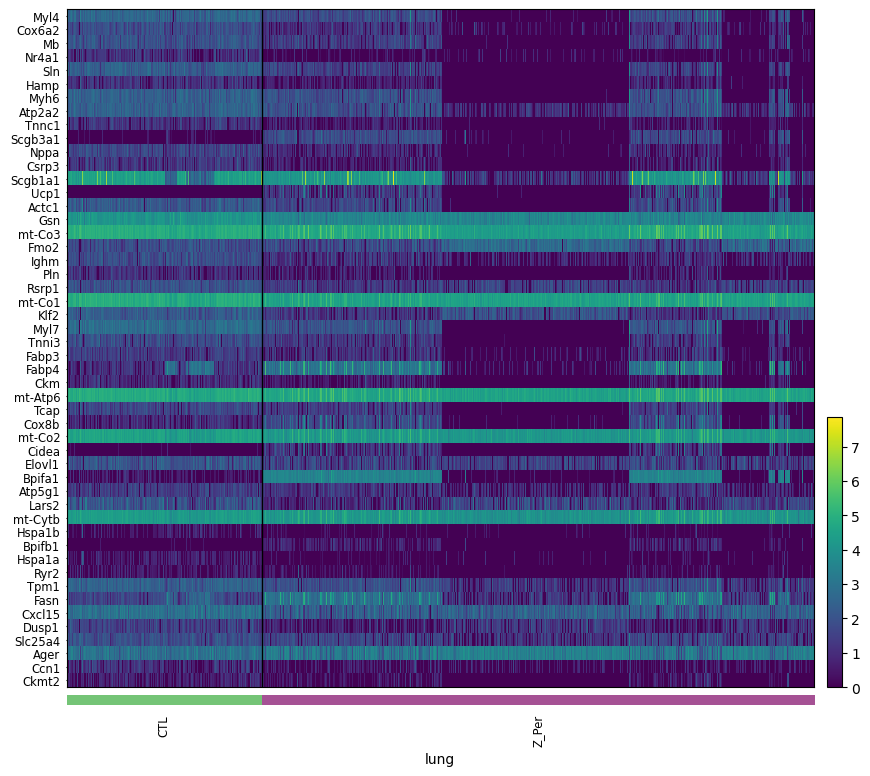

In [22]:
adata_all.uns['lung_colors'] = [plt.cm.tab20c(range(0,20)[9]),
                                plt.cm.tab20b(range(0,20)[17])]
sc.pl.heatmap(adata_all, top_RF_genes, groupby='lung', swap_axes=True,
              use_raw=False)

By observing the spatial expression, we selected the list of genes below to plot on the Kernel density estimation (KDE) plots to view the distribution differences between the two lung conditions.

In [23]:
lstGenes = ['Myl4', 'Cxcl15', 'Scgb3a1', 'Bpifb1', 'Bpifa1',
            'Scgb1a1', 'Sln', 'Hspa1a', 'Nr4a1', 'Ighm', 'Myl7']

In [25]:
def plt_RF (geneName):
  mask = np.isin(adata_all.var_names, geneName)
  total_counts = np.array(adata_all.X[:, mask].sum(axis=1)).flatten()

  df = pd.DataFrame({'counts' : total_counts,
                    'Lung Condition' : adata_all.obs['lung'].tolist()})

  plt.figure(figsize = (6,6))
  my_palette = {'Z_Per' : plt.cm.tab20b(range(0,20)[17]),
                'CTL' : plt.cm.tab20c(range(0,20)[9])}

  ax = sns.displot(df, x='counts', hue='Lung Condition',
                   palette=my_palette, kind='kde', cut=0)
  ax.set(xlabel='Normalized Expression Level', ylabel='Density', title=geneName)

/var/folders/_q/96f_9fwn49v57ybhtdv9075c0000gn/T/ipykernel_77064/1872238638.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (6,6))


<Figure size 600x600 with 0 Axes>

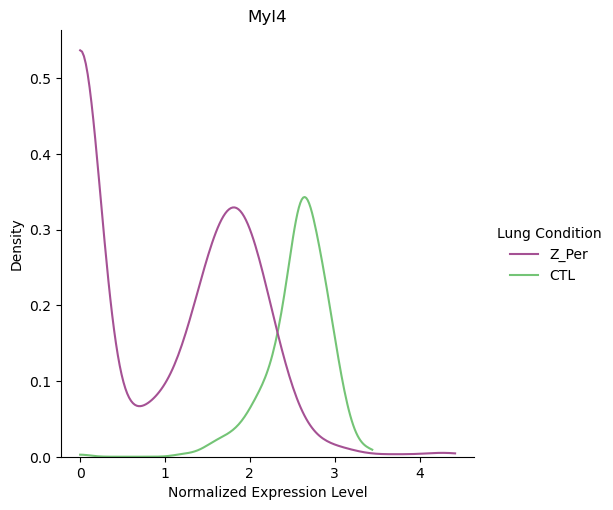

<Figure size 600x600 with 0 Axes>

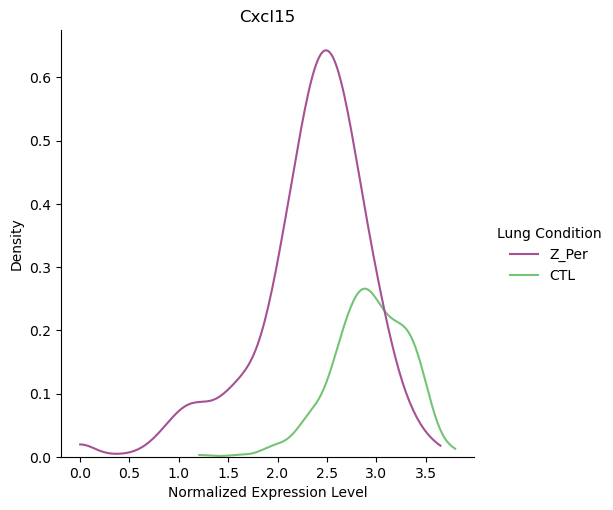

<Figure size 600x600 with 0 Axes>

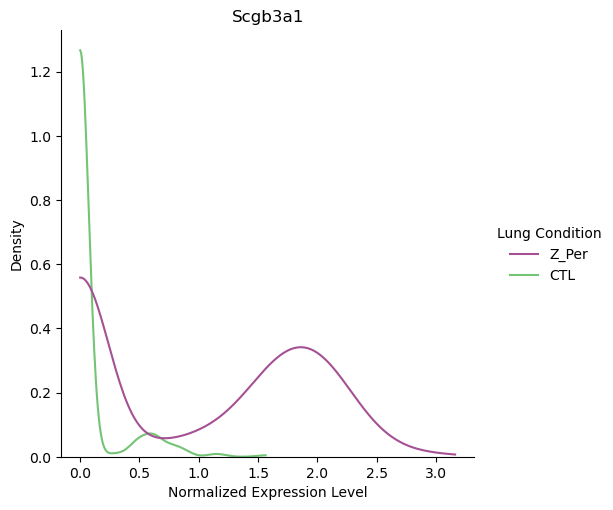

<Figure size 600x600 with 0 Axes>

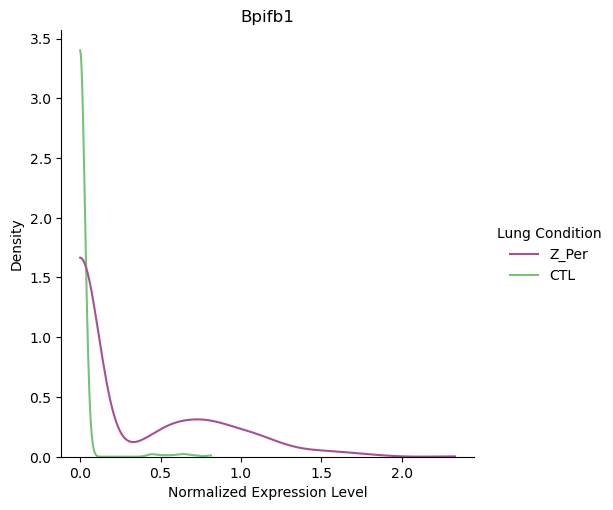

<Figure size 600x600 with 0 Axes>

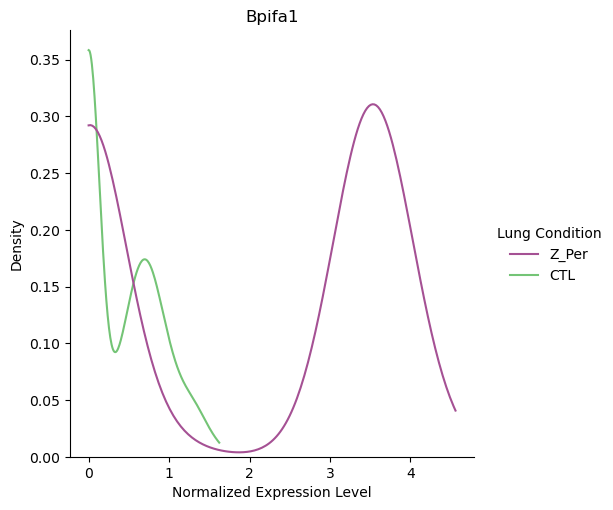

<Figure size 600x600 with 0 Axes>

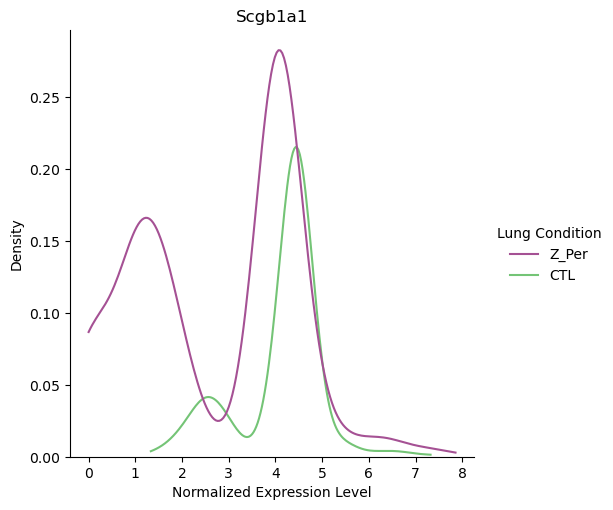

<Figure size 600x600 with 0 Axes>

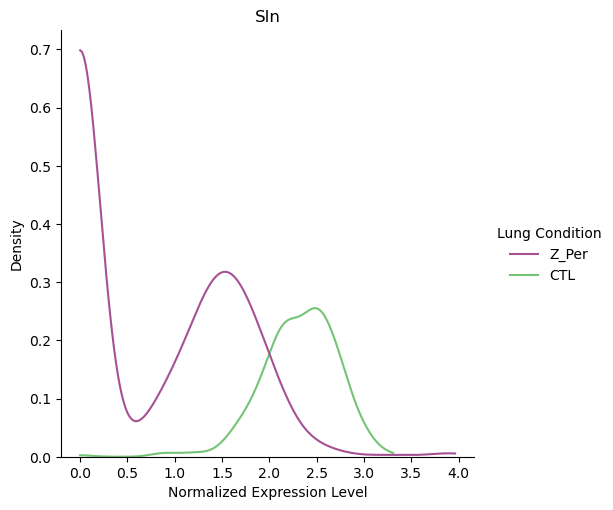

<Figure size 600x600 with 0 Axes>

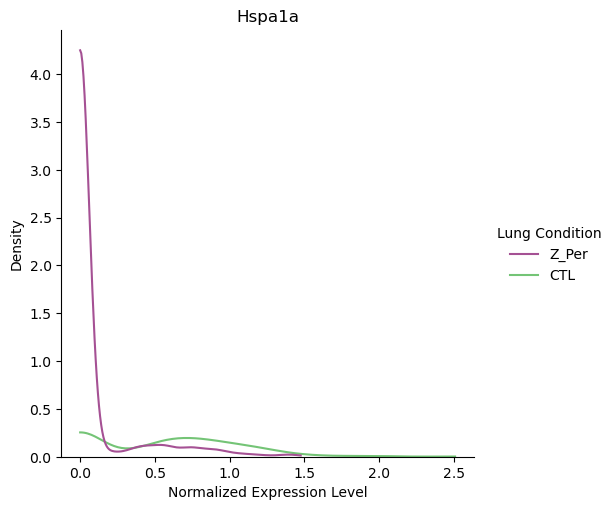

<Figure size 600x600 with 0 Axes>

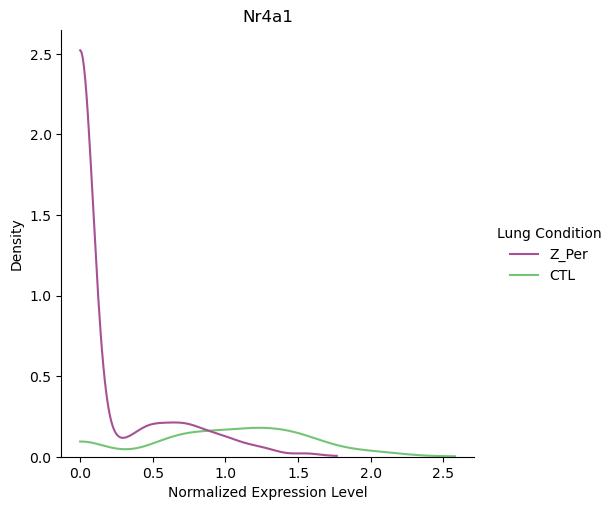

<Figure size 600x600 with 0 Axes>

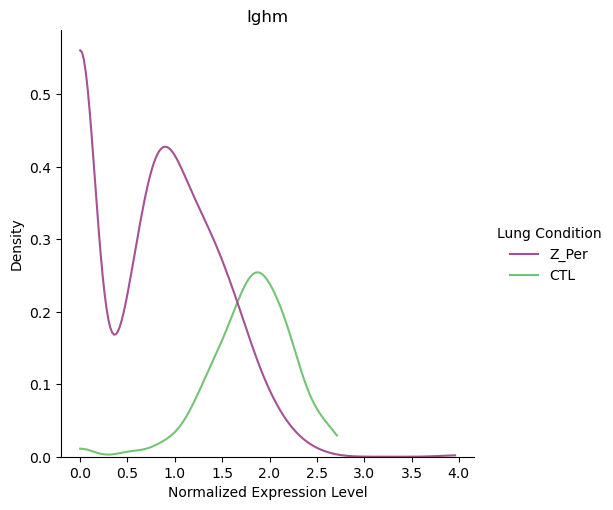

<Figure size 600x600 with 0 Axes>

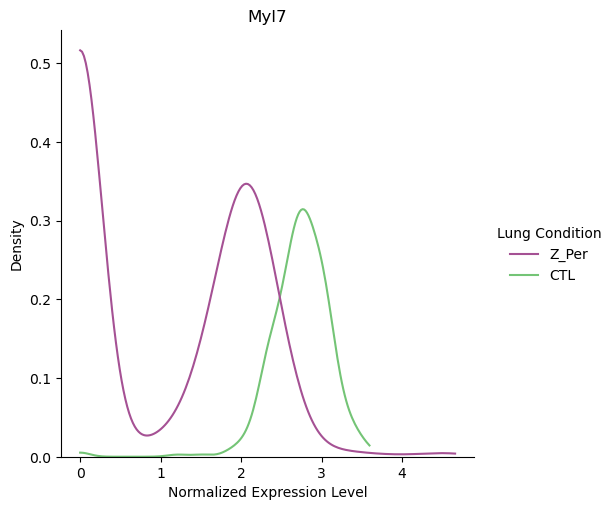

In [26]:
for g in lstGenes:
  plt_RF(g)

## LASSO Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

Scikit-learn uses a parameter $C = \frac{1}{\lambda}$ as the inverse regulation strength. We examined the train and test accuracy using different values $C$ to find the optimal value. We set ```SAGA``` as the solver algorithm, which was known to be faster for large datasets. ```L1``` was used as the penalty which is used by the LASSO regression model to shrink the less important gene’s coefficient to zero, thus, removing them completely.

/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<Axes: xlabel='C', ylabel='accuracy'>

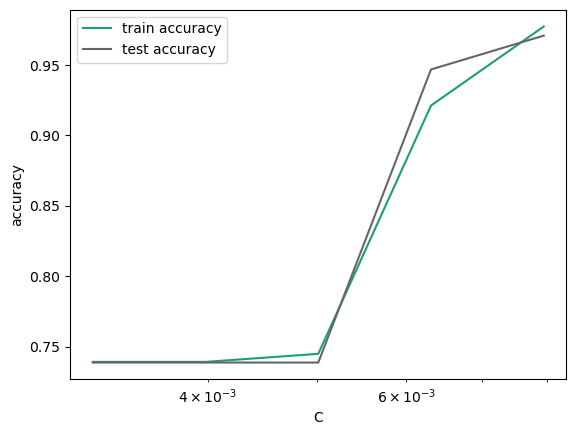

In [28]:
scores = {}
for C in (10**k for k in [x / 10.0 for x in range(-25, -20, 1)]):
    lr = LogisticRegression(C=C, penalty='l1', solver='saga')
    lr.fit(X_train, y_train)
    scores[C] = {'train accuracy': lr.score(X_train, y_train),
                 'test accuracy': lr.score(X_test, y_test)}

# plot the accuracy scores for different values of C
pd.DataFrame.from_dict(scores, 'index').plot(logx=True, xlabel='C',
                                             ylabel='accuracy', colormap='Dark2')

In [29]:
# instantiate the model (optimize a logistic function with a L1 penalty)
logreg = LogisticRegression(C=0.006, penalty='l1', solver='saga')

# fit the model with data
logreg.fit(X_train, y_train)

/Users/anhnguyen/miniconda3/envs/st_project/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.006, penalty='l1', solver='saga')

In [30]:
y_pred = logreg.predict(X_test)

A confusion matrix was computed to identify the number of correct and incorrect predictions. The result showed that the model predicted 340 spots correctly and 35 spots incorrectly.

In [32]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 63,  35],
       [  0, 277]])

Text(0.5, 427.9555555555555, 'Predicted label')

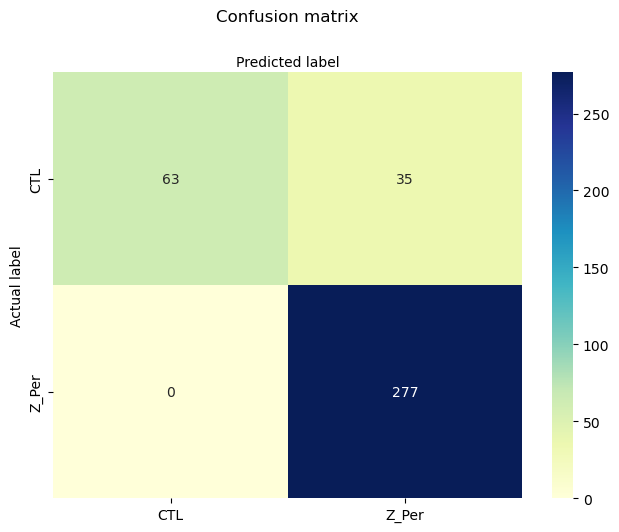

In [33]:
class_names=['CTL', 'Z_Per'] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix, columns=class_names,
                         index=class_names),
            annot=True, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

The area under the curve (AUC) values of the receiver operating characteristic curve (ROC) were evaluated. The results showed that the AUC
of the model was 0.82.

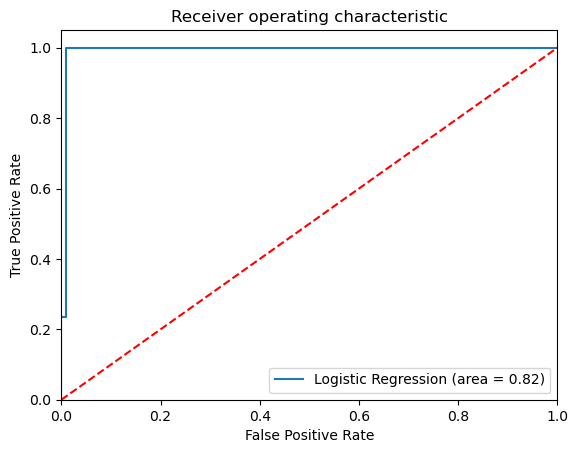

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [37]:
from scipy import stats

In [48]:
index_Genes = np.nonzero(logreg.coef_)[1]
params = np.append(logreg.intercept_,logreg.coef_[np.nonzero(logreg.coef_)])

newX = pd.DataFrame({"Constant":np.ones(len(X_train.iloc[:, index_Genes]))}).join(pd.DataFrame(X_train.iloc[:, index_Genes].reset_index(drop=True)))
MSE = (sum((np.array(y_test) - y_pred)**2))/(len(newX)-len(newX.columns))

sqr_matrix = np.dot(newX.T,newX)
var_b = MSE*(np.linalg.inv(sqr_matrix).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
myDF3

,Coefficients,Standard Errors,t values,Probabilities
0,0.9600,0.047,20.368,0.0
1,0.3825,0.005,83.179,0.0
2,0.0400,0.010,3.872,0.0
3,-0.1076,0.017,-6.464,0.0
4,-0.3804,0.016,-24.285,0.0


In [40]:
from sklearn.feature_selection import chi2

scores, pvalues = chi2(X_train, y_train)

In [42]:
com_dic = {'Gene': X_train.columns,
           'Coefficient':np.ravel(logreg.coef_),
           'pvalues':pvalues}

result = pd.DataFrame(com_dic)

top_genes_LR = result.loc[index_Genes, :]
top_genes_LR = top_genes_LR[top_genes_LR['pvalues'] < 0.05].sort_values('pvalues')
top_genes_LR

,Gene,Coefficient,pvalues
9452,Myl7,-0.380381,2.449733e-72
9449,Myl4,-0.107605,5.855220e-71
2073,Bpifa1,0.382457,1.475920e-52
6983,Hbb-bs,0.039978,9.534929e-04


In [47]:
# intercept
logreg.intercept_[0]

0.9599835

The gene expression levels of the four selected genes demonstrated significant differences between the two lung conditions.

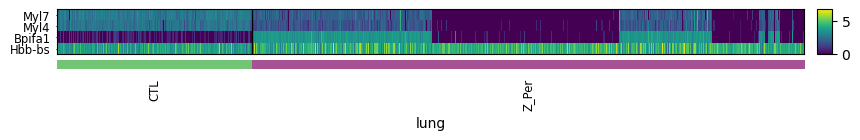

In [43]:
sc.pl.heatmap(adata_all, top_genes_LR['Gene'], groupby='lung',
              swap_axes=True, use_raw=False, show_gene_labels=True)

Non-Vaped samples exhibited consistent gene expression levels, while there was a clear difference between Vaped Male and Vaped Female.

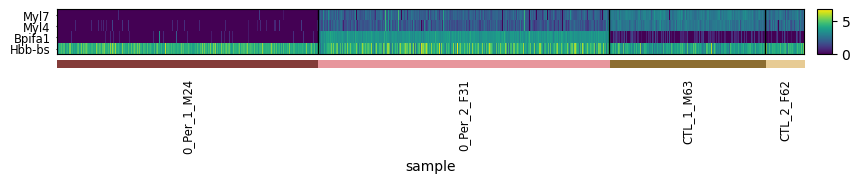

In [44]:
adata_all.uns['sample_colors'] = [plt.cm.tab20b(range(0,20)[12]),
                                  plt.cm.tab20b(range(0,20)[15]),
                                  plt.cm.tab20b(range(0,20)[8]),
                                  plt.cm.tab20b(range(0,20)[11])]

sc.pl.heatmap(adata_all, top_genes_LR['Gene'], groupby='sample',
              swap_axes=True, use_raw=False, show_gene_labels=True)